<a href="https://colab.research.google.com/github/jarek-pawlowski/machine-learning-applications/blob/main/ecg_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Heart beats classification problem
A typical task for applied Machine Learning in medicine is an automatic classification of signals from diagnostic devices such as ECG or EEG

Typical pipeline:
- detect QRS compexes (beats)
- classify them:
> - normal beat N
> - arrhytmia, e.g. *venticular* V, *supraventicular* S arrytmia, or *artial fibrillation* AF

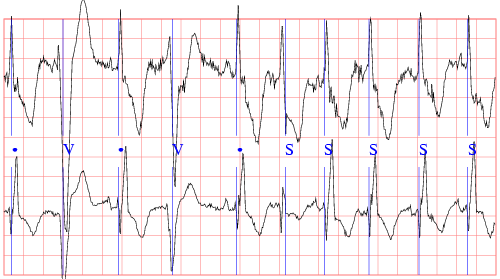

![ECG signal](https://ars.els-cdn.com/content/image/1-s2.0-S0950705120307188-gr1.jpg)

a couple of links:
- [exemplary challenge from Physionet](https://physionet.org/content/challenge-2017/1.0.0/)
- [some recent paper on ECG classification](https://doi.org/10.1016/j.knosys.2020.106589)

## our challenge: classify beats as normal or abnormal (arrhytmia)
- we will utilize signals from **svdb** database, and grab subsequent beats (data preprocessing)
- then construct binary classifier using NN, decision trees, ensemble metchods, and SVM or NaiveBayes

# Dataset preparation
1. Download ecg waves from **svdb** database provided by *PhysioNet*
2. Divide signals into samples, each containing single heartbeat (with window size of 96 points, *sampling ratio* = 128 points/s)
3. Take only samples annotated as 'N' (normal beat), or 'S' and 'V' (arrhythmias)

In [1]:
import os
import numpy as np

# install PhysioNet ecg data package 
!pip install wfdb
import wfdb

# list of available datasets
dbs = wfdb.get_dbs()
display(dbs)

# we choose svdb
svdb_dir = os.path.join(os.getcwd(), 'svdb_dir')
wfdb.dl_database('svdb', dl_dir=svdb_dir)

# Display the  downloaded content
svdb_in_files = [os.path.splitext(f)[0] for f in os.listdir(svdb_dir) if f.endswith('.dat')]
print(svdb_in_files)

[['aami-ec13', 'ANSI/AAMI EC13 Test Waveforms'],
 ['accelerometry-walk-climb-drive',
  'Labeled raw accelerometry data captured during walking, stair climbing and driving'],
 ['adfecgdb', 'Abdominal and Direct Fetal ECG Database'],
 ['afdb', 'MIT-BIH Atrial Fibrillation Database'],
 ['afpdb', 'PAF Prediction Challenge Database'],
 ['aftdb', 'AF Termination Challenge Database'],
 ['ahadb', 'AHA Database Sample Excluded Record'],
 ['antimicrobial-resistance-uti',
  'AMR-UTI: Antimicrobial Resistance in Urinary Tract Infections'],
 ['apnea-ecg', 'Apnea-ECG Database'],
 ['auditory-eeg', 'Auditory evoked potential EEG-Biometric dataset'],
 ['autonomic-aging-cardiovascular',
  'Autonomic Aging: A dataset to quantify changes of cardiovascular autonomic function during healthy aging'],
 ['bhx-brain-bounding-box',
  'Brain Hemorrhage Extended (BHX): Bounding box extrapolation from thick to thin slice CT images'],
 ['bidmc', 'BIDMC PPG and Respiration Dataset'],
 ['bigideaslab-step-hr-smartwatch

Generating record list for: 800
Generating record list for: 801
Generating record list for: 802
Generating record list for: 803
Generating record list for: 804
Generating record list for: 805
Generating record list for: 806
Generating record list for: 807
Generating record list for: 808
Generating record list for: 809
Generating record list for: 810
Generating record list for: 811
Generating record list for: 812
Generating record list for: 820
Generating record list for: 821
Generating record list for: 822
Generating record list for: 823
Generating record list for: 824
Generating record list for: 825
Generating record list for: 826
Generating record list for: 827
Generating record list for: 828
Generating record list for: 829
Generating record list for: 840
Generating record list for: 841
Generating record list for: 842
Generating record list for: 843
Generating record list for: 844
Generating record list for: 845
Generating record list for: 846
Generating record list for: 847
Generati

In [44]:
time_window = 48
all_beats = []
all_annotations = []
for in_file in svdb_in_files:
    print('...processing...' + in_file + '...file')
    signal, fields = wfdb.rdsamp(os.path.join(svdb_dir,in_file), channels=[0])
    annotations = wfdb.rdann(os.path.join(svdb_dir,in_file), 'atr')
    signal=np.array(signal).flatten()
    # grab subsequent heartbeats within [position-48,position+48] window
    beats = np.zeros((len(annotations.sample[5:-5]), time_window*2))
    # note that we remove first and last few beats to ensure that all beats have equal lengths
    for i, ann_position in enumerate(annotations.sample[5:-5]):
        beats[i] = signal[ann_position-time_window:ann_position+time_window]
    all_beats.append(beats)
    # consequently, we remove first and last few annotations
    all_annotations.append(annotations.symbol[5:-5])

all_beats = np.concatenate(all_beats)
all_annotations = np.concatenate(all_annotations)

# check which annotations are usable for us, are of N or S or V class
indices = [i for i, ann in enumerate(all_annotations) if ann in {'N','S','V'}]
# and get only these
all_beats = all_beats[indices]
all_annotations = np.array([all_annotations[i] for i in indices])

# print data statistics
print(all_beats.shape, all_annotations.shape)
print('no of N beats: ' + str(np.count_nonzero(all_annotations == 'N')))
print('no of S beats: ' + str(np.count_nonzero(all_annotations == 'S')))
print('no of V beats: ' + str(np.count_nonzero(all_annotations == 'V')))

...processing...888...file
...processing...811...file
...processing...824...file
...processing...859...file
...processing...868...file
...processing...846...file
...processing...878...file
...processing...864...file
...processing...887...file
...processing...851...file
...processing...823...file
...processing...805...file
...processing...870...file
...processing...871...file
...processing...829...file
...processing...826...file
...processing...842...file
...processing...863...file
...processing...800...file
...processing...812...file
...processing...807...file
...processing...849...file
...processing...883...file
...processing...848...file
...processing...809...file
...processing...858...file
...processing...840...file
...processing...845...file
...processing...857...file
...processing...821...file
...processing...810...file
...processing...894...file
...processing...867...file
...processing...889...file
...processing...853...file
...processing...808...file
...processing...866...file
.

['N' 'N' 'N' 'N' 'N' 'N' 'V' 'N' 'S' 'N' 'N' 'N' 'V' 'N' 'N' 'N' 'N' 'N'
 'S' 'N' 'N' 'N' 'S' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'V'
 'N' 'N' 'N' 'N' 'S' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N'
 'S' 'N' 'N' 'N' 'N' 'N' 'N' 'S' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N'
 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N'
 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N']


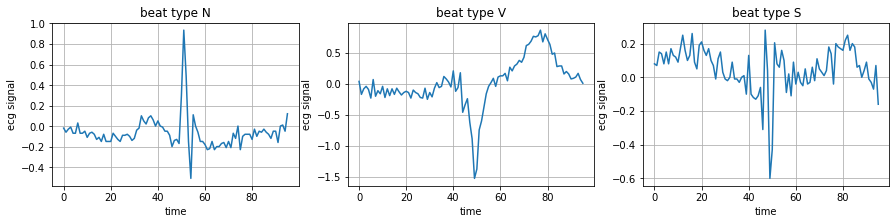

In [45]:
# show example samples
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3)
fig.set_size_inches(15, 3)
plt.subplots_adjust(wspace=0.2)
print(all_annotations[:100])
sample_number = [0,6,8]
for i, sn in enumerate(sample_number):
    ax[i].plot(all_beats[sn])
    ax[i].set(xlabel='time', ylabel='ecg signal', title='beat type ' + all_annotations[sn])
    ax[i].grid()
plt.show()

# Experiments

0. Preliminaries
> - Divide dataset into train/validation/test subset, and normalize each of them. 
> - Define classification accuracy metrics (dataset is imbalanced)
>>Confusion matrix
```
____Prediction
T |   n  s  v
r |N  Nn Ns Nv
u |S  Sn Ss Sv
t |V  Vn Vs Vv
h | 
```
>> - Total accuracy
$Acc_T = \frac{Nn+Ss+Vv}{\Sigma_N+\Sigma_S+\Sigma_V}$,
>> - Arrhythmia accuracy (S or V cases are more important to be detected):
$Acc_A = \frac{Ss+Vv}{\Sigma_S+\Sigma_V}$,
>> - $\Sigma_N=Nn+Ns+Nv$, $\Sigma_S=Sn+Ss+Sv$,
$\Sigma_V=Vn+Vs+Vv$

1. Standard classifiers: *naive Bayes* and *SVM*
2. Decision Tree with optimized max_depth
3. Random Forest with vector of features

In [50]:
# prepare datasets and define error metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# to simplify experiments and speedup training 
# we take only some part of the whole dataset
X, y = all_beats[::10], all_annotations[::10]

# train/validation/test set splitting 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15/0.85, random_state=0)
print(len(y_train), len(y_val), len(y_test))

# perform data normalization: z = (x - u)/s
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
# same for the validation subset
X_val = preprocessing.StandardScaler().fit_transform(X_val)
# and for the test subset
X_test = preprocessing.StandardScaler().fit_transform(X_test)

# define accuracy
def calculate_accuracy(y_pred, y_gt, comment='', printout=True):
    acc_t = np.count_nonzero(y_pred == y_gt)/len(y_gt)
    acc_a = np.count_nonzero(
        np.logical_and(y_pred == y_gt, y_gt != 'N'))/np.count_nonzero(y_gt != 'N')
    if printout is True:
        print('-----------------------------------')    
        print(comment)
        print('Total accuracy, Acc_T = {:.4f}'.format(acc_t))
        print('Arrhythmia accuracy, Acc_A = {:.4f}'.format(acc_a))
        print('-----------------------------------')
    else: return acc_t, acc_a 

12859 2756 2756


In [74]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
calculate_accuracy(y_pred, y_test, comment='naive Bayes classifier')

svc = SVC()
y_pred = svc.fit(X_train, y_train).predict(X_test)
calculate_accuracy(y_pred, y_test, comment='SVM classifier')

svc = SVC(class_weight='balanced')
y_pred = svc.fit(X_train, y_train).predict(X_test)
calculate_accuracy(y_pred, y_test, comment='balanced SVM classifier')

-----------------------------------
naive Bayes classifier
Total accuracy, Acc_T = 0.8251
Arrhythmia accuracy, Acc_A = 0.3919
-----------------------------------
-----------------------------------
SVM classifier
Total accuracy, Acc_T = 0.9383
Arrhythmia accuracy, Acc_A = 0.5303
-----------------------------------
-----------------------------------
balanced SVM classifier
Total accuracy, Acc_T = 0.9224
Arrhythmia accuracy, Acc_A = 0.7954
-----------------------------------


Summary of this part:
1. The goal is to maximize both metrics Acc_T and Acc_A at the same time
1. naive Bayes performs rather poorly
> - problem with data imbalace
2. SVM has simillar problem, but after data balacing works quite good

-----------------------------------
balanced DT
Total accuracy, Acc_T = 0.8512
Arrhythmia accuracy, Acc_A = 0.7291
-----------------------------------
1 0.1001 0.7562
2 0.1121 0.8466
3 0.8875 0.4493
4 0.8345 0.4822
5 0.8110 0.5945
6 0.7812 0.6466
7 0.8237 0.6247
8 0.8618 0.6466
9 0.8650 0.6438
10 0.8759 0.6466
11 0.7656 0.7178
12 0.7805 0.7288
13 0.7972 0.7205
14 0.7605 0.7315
15 0.8153 0.7178
16 0.8091 0.7205
17 0.8320 0.7233
18 0.8208 0.7178
19 0.8335 0.7068
20 0.8364 0.7096
21 0.8345 0.7096
22 0.8389 0.7123
23 0.8371 0.7068
24 0.8411 0.7068
25 0.8403 0.7123


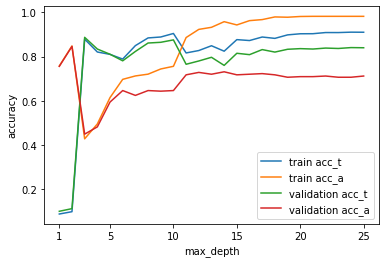

In [51]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(criterion='entropy', 
                             class_weight='balanced', 
                             min_samples_leaf=10)
y_pred = dtc.fit(X_train, y_train).predict(X_test)
calculate_accuracy(y_pred, y_test, comment='balanced DT')

# tunning max_dept hyperparameter (DT likes to overfit)
train_acc_t = []
train_acc_a = []
val_acc_t = []
val_acc_a = []
depth_range = range(1,26)
for max_depth in depth_range:
    dtc = DecisionTreeClassifier(criterion='entropy', 
                                 class_weight='balanced', 
                                 min_samples_leaf=10,
                                 max_depth=max_depth)
    dt_fit = dtc.fit(X_train, y_train)
    y_pred_train = dt_fit.predict(X_train)
    y_pred_val = dt_fit.predict(X_val)    
    acc_t_train, acc_a_train = calculate_accuracy(y_pred_train, y_train, printout=False)
    acc_t_val, acc_a_val = calculate_accuracy(y_pred_val, y_val, printout=False)
    train_acc_t.append(acc_t_train)
    train_acc_a.append(acc_a_train)
    val_acc_t.append(acc_t_val)
    val_acc_a.append(acc_a_val)
    print('{0:d} {1:.4f} {2:4.4f}'.format(max_depth, acc_t_val, acc_a_val))

import matplotlib.pyplot as plt
_, ax = plt.subplots()
ax.plot(depth_range, train_acc_t, label='train acc_t')
ax.plot(depth_range, train_acc_a, label='train acc_a')
ax.plot(depth_range, val_acc_t, label='validation acc_t')
ax.plot(depth_range, val_acc_a , label='validation acc_a')
ax.set(xlabel='max_depth', ylabel='accuracy')
ax.xaxis.set_ticks([1, 5, 10, 15, 20, 25])
ax.legend()
plt.show()

In [63]:
# optimum acc_a max_depth
dtc = DecisionTreeClassifier(criterion='entropy', 
                             class_weight='balanced',
                             min_samples_leaf=10,
                             max_depth=10)
y_pred = dtc.fit(X_train, y_train).predict(X_test)
calculate_accuracy(y_pred, y_test, comment='DT: Acc_A maximized')

# optimum acc_t & acc_a max_depth
dtc = DecisionTreeClassifier(criterion='entropy', 
                             class_weight='balanced',
                             min_samples_leaf=10,
                             max_depth=14)
y_pred = dtc.fit(X_train, y_train).predict(X_test)
calculate_accuracy(y_pred, y_test, comment='DT: Acc_T + Acc_A maximized')

-----------------------------------
DT: Acc_A maximized
Total accuracy, Acc_T = 0.8813
Arrhythmia accuracy, Acc_A = 0.6455
-----------------------------------
-----------------------------------
DT: Acc_T + Acc_A maximized
Total accuracy, Acc_T = 0.7587
Arrhythmia accuracy, Acc_A = 0.7579
-----------------------------------


In [53]:
# feature vector via PCA (dimensionlality reduction) works poorly
from sklearn.decomposition import PCA
pca = PCA(n_components=15)
X_train_ = pca.fit_transform(X_train)
X_test_ = pca.fit_transform(X_test)

dtc = DecisionTreeClassifier(criterion='entropy', 
                             class_weight='balanced', 
                             min_samples_leaf=10,
                             max_depth=10)
y_pred = dtc.fit(X_train_, y_train).predict(X_test_)
calculate_accuracy(y_pred, y_test, comment='DT with PCA')

-----------------------------------
DT with PCA
Total accuracy, Acc_T = 0.5439
Arrhythmia accuracy, Acc_A = 0.4092
-----------------------------------


Summary:
1. Decision Tree works a bit worse (than SVM) and has tendency to overfit. We consider two types of hyperparameters:
> - *max_depth*
> - *min_samples_leaf*
2. Tunning *max_depth* gives Acc_A (*max_depth*=8), or Acc_T & Acc_A (*max_depth*=13) maximum value
3. Simple dimensionality reduction using PCA works rather poorly

In [73]:
import pywt

# extract features using different wavelets and simple differences
def extract_features(input_sample):
    out = np.array([])
# sym8
    cA = pywt.downcoef('a', input_sample, 'sym8', level=4, mode='per')
    out = np.append(out,cA)
    cD = pywt.downcoef('d', input_sample, 'sym8', level=4, mode='per')
    out = np.append(out,cD)
# db6/9
    cA = pywt.downcoef('a', input_sample, 'db6', level=4, mode='per')
    out = np.append(out,cA)
    cD = pywt.downcoef('d', input_sample, 'db6', level=4, mode='per')
    out = np.append(out,cD)
    cA = pywt.downcoef('a', input_sample, 'db9', level=4, mode='per')
    out = np.append(out,cA)
    cD = pywt.downcoef('d', input_sample, 'db9', level=4, mode='per')
    out = np.append(out,cD)
# dmey
    cA = pywt.downcoef('a', input_sample, 'dmey', level=4, mode='per')
    out = np.append(out,cA)
    cD = pywt.downcoef('d', input_sample, 'dmey', level=4, mode='per')
    out = np.append(out,cD)

# differences
    differences = np.zeros(16)
    for i, t in enumerate(range(40, 56)):
        differences[i] = input_sample[t+1]-input_sample[t]
    out = np.append(out,differences)
    return out

# collect vector of features for all samples
def data_features(input_data):
    return np.array([extract_features(sample) for sample in input_data])

X_train_ = data_features(X_train)
print(X_train_.shape)
X_test_ = data_features(X_test)
print(X_test_.shape)

dtc = DecisionTreeClassifier(criterion='entropy', 
                             class_weight='balanced', 
                             min_samples_leaf=10,
                             max_depth=15)
y_pred = dtc.fit(X_train_, y_train).predict(X_test_)
calculate_accuracy(y_pred, y_test, comment='DT with wavelets')

from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(criterion='entropy', 
                             n_estimators=500, 
                             max_depth=10, 
                             class_weight='balanced')
y_pred = rfc.fit(X_train_, y_train).predict(X_test_)
calculate_accuracy(y_pred, y_test, comment='RF with wavelets')

from sklearn.ensemble import AdaBoostClassifier

abc = AdaBoostClassifier(n_estimators=200)
y_pred = abc.fit(X_train_, y_train).predict(X_test_)
calculate_accuracy(y_pred, y_test, comment='Ada with wavelets')

(12859, 64)
(2756, 64)
-----------------------------------
DT with wavelets
Total accuracy, Acc_T = 0.8545
Arrhythmia accuracy, Acc_A = 0.7435
-----------------------------------
-----------------------------------
RF with wavelets
Total accuracy, Acc_T = 0.9445
Arrhythmia accuracy, Acc_A = 0.6801
-----------------------------------
-----------------------------------
Ada with wavelets
Total accuracy, Acc_T = 0.8984
Arrhythmia accuracy, Acc_A = 0.4755
-----------------------------------


# Tasks to do 
Please choose and complete just **one** of them:
1. Modify classifier to get **accuracy > 0.81** for both Acc_T *and* Acc_A
> - play with classifier hyperparameters
> - add some other features, e.g:
>> - [mean of absolute value (MAV) of signal](https://www.researchgate.net/publication/46147272_Sequential_algorithm_for_life_threatening_cardiac_pathologies_detection_based_on_mean_signal_strength_and_EMD_functions)
>> - some other signal features from [scipy signal](https://docs.scipy.org/doc/scipy/reference/signal.html#peak-finding), 
>> - distances between previous and next heartbeats are strong features, see e.g. [here](https://link.springer.com/article/10.1007/s11760-009-0136-1),
>> - it may be also usefull to perform some feature selection, e.g. choose these with variance higher than some assumed threshold (*intuition*: variance measures amount of information in a given feature), or use *model.feature_importances_* attribute (for more see [here](https://scikit-learn.org/stable/modules/feature_selection.html))
> - balance dataset by yourself: equalize the size of each of 3 groups (hint: take the whole dataset)
> - or build your own classifier using [MLP](https://scikit-learn.org/stable/modules/neural_networks_supervised.html#classification) 
2. Compare results for Random Forest with AdaBoost classifier
> - try to figure out why the default Ada setup won't work good
> - and fix this problem (hint: resampling)
> - try Ada with different *base_estimators*
3. Add deep-neural classifier (like one in previous lab) and compare its preformance with today's best classifier
> - at first you should create *torch.utils.data.DataLoader* object, see [here](https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel)